In [1]:
%matplotlib inline

import pandas as pd; pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler

class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


class RenameKey(BaseEstimator, TransformerMixin):
    def __init__(self, new_old_keys_dict):
        self.new_old_keys_dict = new_old_keys_dict

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.rename(self.new_old_keys_dict, axis='columns')
        return X
    
    
class BinEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key, neg_class='No Offer'):
        self.key = key
        self.neg_class = neg_class

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.neg_class in X[self.key].unique():
            X.loc[(X[self.key] != self.neg_class), self.key ] = 1
            X.loc[(X[self.key] == self.neg_class), self.key ] = 0
            X[self.key] = pd.to_numeric(X[self.key])
            return X[[self.key]]

class UpliftSegmentation(BaseEstimator, TransformerMixin):
    def __init__(self,  key_treatment='treatment', key_target='target', segmentation_key='uplift_seg_class'):
        self.key_treatment = key_treatment
        self.key_target = key_target
        self.segmentation_key = segmentation_key
    
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Lost couses:
        X[self.segmentation_key] = 0 
        # Sure Things:
        X.loc[(X[self.key_treatment] == 0) & (X[self.key_target] != 0), self.segmentation_key] = 1 
        # Sleeping dogs:
        X.loc[(X[self.key_treatment] != 0) & (X[self.key_target] == 0), self.segmentation_key] = 2 
        # Persuadables:
        X.loc[(X[self.key_treatment] != 0) & (X[self.key_target] != 0), self.segmentation_key] = 3 
        return X

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [2]:
file_name='C:/Users/razov/Documents/Библиотеки Python/HW_data.csv'
df_base=pd.read_csv(file_name)
df_base.columns

Index(['recency', 'history', 'used_discount', 'used_bogo', 'zip_code',
       'is_referral', 'channel', 'offer', 'conversion'],
      dtype='object')

2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [3]:
rename_feture = RenameKey({'conversion': 'target', 'offer': 'treatment'})

In [4]:
df_base = rename_feture.fit_transform(df_base)

In [5]:
df_base.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [6]:
treatment = BinEncoder(key='treatment')
treatment.fit_transform(df_base).head(3)

,treatment
0,1
1,0
2,1


In [7]:
df_base.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


In [8]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   treatment      64000 non-null  int64  
 8   target         64000 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 4.4+ MB


Разбиваем выборку на две ( одна с комуникацией другая без неё)

In [9]:
df_false_treatment = df_base.copy().loc[df_base.treatment <= 0].reset_index(drop=True)
df_true_treatment = df_base.copy().loc[df_base.treatment > 0].reset_index(drop=True)

In [10]:
df_false_treatment.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,6,329.08,1,1,Rural,1,Web,0,0
1,4,241.42,0,1,Rural,1,Multichannel,0,0
2,3,58.13,1,0,Urban,1,Web,0,1


In [11]:
df_true_treatment.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,7,180.65,0,1,Surburban,1,Web,1,0
2,9,675.83,1,0,Rural,1,Web,1,0


In [12]:
df_false_treatment_seg = UpliftSegmentation()
df_false_treatment_seg.fit_transform(df_false_treatment).head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,uplift_seg_class
0,6,329.08,1,1,Rural,1,Web,0,0,0
1,4,241.42,0,1,Rural,1,Multichannel,0,0,0
2,3,58.13,1,0,Urban,1,Web,0,1,1


In [13]:
df_false_treatment.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,uplift_seg_class
0,6,329.08,1,1,Rural,1,Web,0,0,0
1,4,241.42,0,1,Rural,1,Multichannel,0,0,0
2,3,58.13,1,0,Urban,1,Web,0,1,1


In [15]:
df_true_treatment_seg = UpliftSegmentation()
df_true_treatment_seg.fit_transform(df_true_treatment).head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,uplift_seg_class
0,10,142.44,1,0,Surburban,0,Phone,1,0,2
1,7,180.65,0,1,Surburban,1,Web,1,0,2
2,9,675.83,1,0,Rural,1,Web,1,0,2


In [16]:
df_true_treatment.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,uplift_seg_class
0,10,142.44,1,0,Surburban,0,Phone,1,0,2
1,7,180.65,0,1,Surburban,1,Web,1,0,2
2,9,675.83,1,0,Rural,1,Web,1,0,2


Проводим сегментацию на базовой выборке

In [17]:
df_base_treatment_seg = UpliftSegmentation()
df_base_treatment_seg.fit_transform(df_base).head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,uplift_seg_class
0,10,142.44,1,0,Surburban,0,Phone,1,0,2
1,6,329.08,1,1,Rural,1,Web,0,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0,2


3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [18]:
X = df_base.drop(['target','uplift_seg_class'], axis=1)
y = df_base.target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [19]:
recency =  Pipeline([
                ('selector', NumberSelector(key='recency')),
                ('standard', StandardScaler())
            ])
history =  Pipeline([
                ('selector', NumberSelector(key='history')),
                ('standard', StandardScaler())
            ])

In [20]:
zip_code = Pipeline([
                ('selector', ColumnSelector(key='zip_code')),
                ('ohe', OHEEncoder(key='zip_code'))
            ])
channel = Pipeline([
                ('selector', ColumnSelector(key='channel')),
                ('ohe', OHEEncoder(key='channel'))
            ])

In [21]:
continuos_features = Pipeline([
                ('selector', ColumnSelector(key=['used_discount',
                                                 'used_bogo',
                                                 'is_referral']))
            ])

In [22]:
feats = FeatureUnion([('recency', recency),
                      ('history', history),
                      ('zip_code', zip_code),
                      ('channel', channel),
                      ('continuos_features', continuos_features)])
feature_processing = Pipeline([('feats', feats)])

In [23]:
from sklearn.ensemble import RandomForestClassifier
pipeline = Pipeline([
    ('features', feats),
    ('classifier', RandomForestClassifier(random_state = 21)),
])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('recency',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='recency')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('history',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='history')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('zip_code',
                                                 Pipeline(steps=[('selector',
                            

In [24]:
preds = pipeline.predict_proba(X_test)
preds

array([[0.72, 0.28],
       [0.97, 0.03],
       [0.08, 0.92],
       ...,
       [1.  , 0.  ],
       [0.97, 0.03],
       [0.94, 0.06]])

In [25]:
df_base.recency = recency.transform(df_base)
df_base.history = history.transform(df_base)
df_base

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target,uplift_seg_class
0,1.204924,-0.389112,1,0,Surburban,0,Phone,1,0,2
1,0.065492,0.341694,1,1,Rural,1,Web,0,0,0
2,0.350350,-0.239497,0,1,Surburban,1,Web,1,0,2
3,0.920066,1.699425,1,0,Rural,1,Web,1,0,2
4,-1.073941,-0.769316,1,0,Urban,0,Web,1,0,2
...,...,...,...,...,...,...,...,...,...,...
63995,1.204924,-0.533597,1,0,Urban,0,Web,1,0,2
63996,-0.219366,-0.794493,0,1,Urban,1,Phone,1,0,2
63997,0.065492,-0.829420,1,0,Urban,1,Phone,1,0,2
63998,-1.358799,1.218238,1,0,Surburban,1,Multichannel,1,0,2


In [26]:
X = df_base.drop(['target','uplift_seg_class'], axis=1)
y = df_base.target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

treat_train = X_train.treatment
X_train = X_train.drop(['treatment'], axis=1)

treat_test  =  X_test.treatment
X_test = X_test.drop(['treatment'], axis=1)

In [27]:
cat_features = X_train.columns[2:].to_list()

models_results = {
    'approach': [],
    'uplift@30%': [],
    'uplift@20%': [],
    'uplift@10%': []
}

X_train.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
9748,1.204924,-0.271331,0,1,Surburban,0,Web
46676,0.920066,-0.307354,1,0,Surburban,1,Web
2400,0.635208,-0.016661,1,0,Urban,0,Web


5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

### SoloModel

In [29]:
!pip install scikit-uplift

uplift@30%: 0.0828


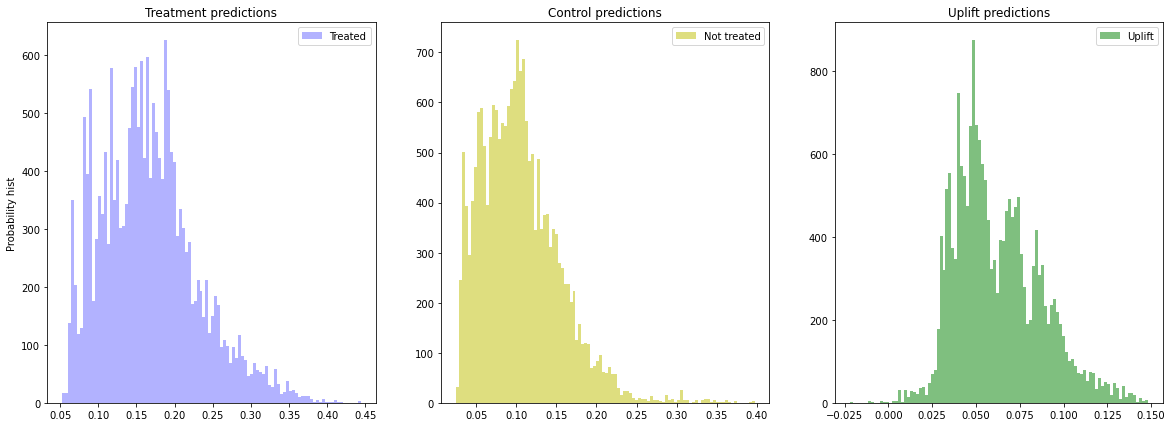

In [30]:
# Инструкция по установке пакета: https://github.com/maks-sh/scikit-uplift
# Ссылка на документацию: https://scikit-uplift.readthedocs.io/en/latest/
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=21, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)
print(f'uplift@30%: {sm_score:.4f}')

models_results['approach'].append('SoloModel')
models_results['uplift@30%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [31]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,20.762934
1,is_referral,19.804503
2,used_bogo,10.973552
3,recency,10.768669
4,zip_code,10.739712
5,history,9.331882
6,used_discount,9.327490
7,channel,8.291257


### ClassTransformation

In [32]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=21, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('ClassTransformation')
models_results['uplift@30%'].append(ct_score)

### TwoModels

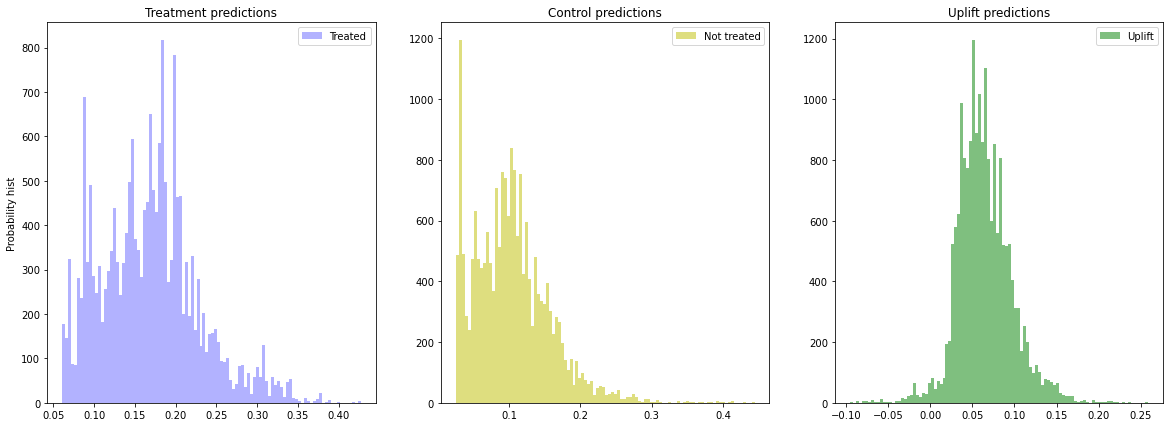

In [33]:
from sklift.models import TwoModels


tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['approach'].append('TwoModels')
models_results['uplift@30%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [34]:
models_results

{'approach': ['SoloModel', 'ClassTransformation', 'TwoModels'],
 'uplift@30%': [0.08281222855563902, 0.06776304540225406, 0.07257698931526599],
 'uplift@20%': [],
 'uplift@10%': []}

### 20%

In [35]:
X = df_base.drop(['target','uplift_seg_class'], axis=1)
y = df_base.target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

treat_train = X_train.treatment
X_train = X_train.drop(['treatment'], axis=1)

treat_test  =  X_test.treatment
X_test = X_test.drop(['treatment'], axis=1)

### SoloModel

uplift@20%: 0.0586


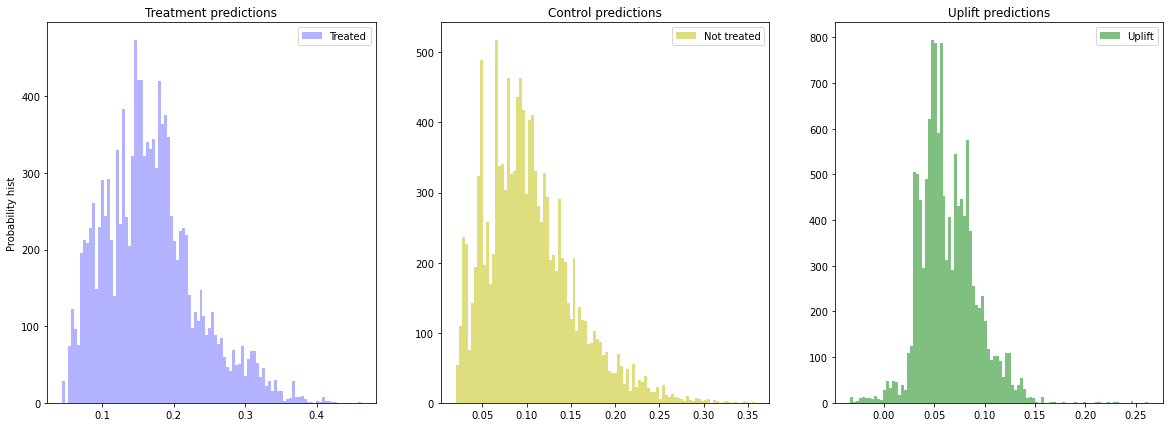

In [36]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=21, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)
print(f'uplift@20%: {sm_score:.4f}')
models_results['uplift@20%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [37]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,21.078982
1,treatment,18.197843
2,used_bogo,12.370253
3,recency,12.089725
4,zip_code,10.663443
5,used_discount,8.980814
6,history,8.479017
7,channel,8.139922


### ClassTransformation

In [38]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=21, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['uplift@20%'].append(ct_score)

### TwoModels

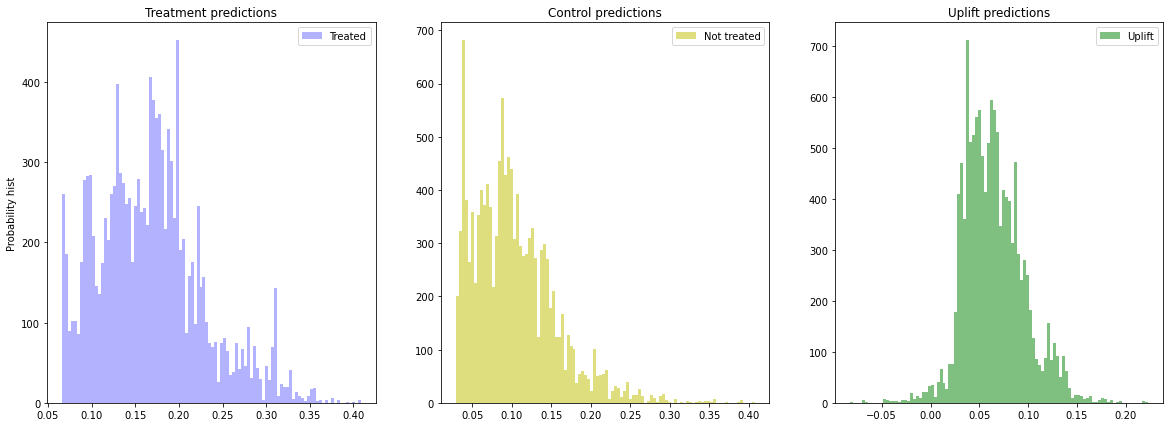

In [39]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=21, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=21, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['uplift@20%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [40]:
models_results

{'approach': ['SoloModel', 'ClassTransformation', 'TwoModels'],
 'uplift@30%': [0.08281222855563902, 0.06776304540225406, 0.07257698931526599],
 'uplift@20%': [0.058585625357888305,
  0.05399757405594449,
  0.07615524810511604],
 'uplift@10%': []}

### 10%

In [41]:
X = df_base.drop(['target','uplift_seg_class'], axis=1)
y = df_base.target


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=21)

treat_train = X_train.treatment
X_train = X_train.drop(['treatment'], axis=1)

treat_test  =  X_test.treatment
X_test = X_test.drop(['treatment'], axis=1)

### SoloModel

uplift@10%: 0.0705


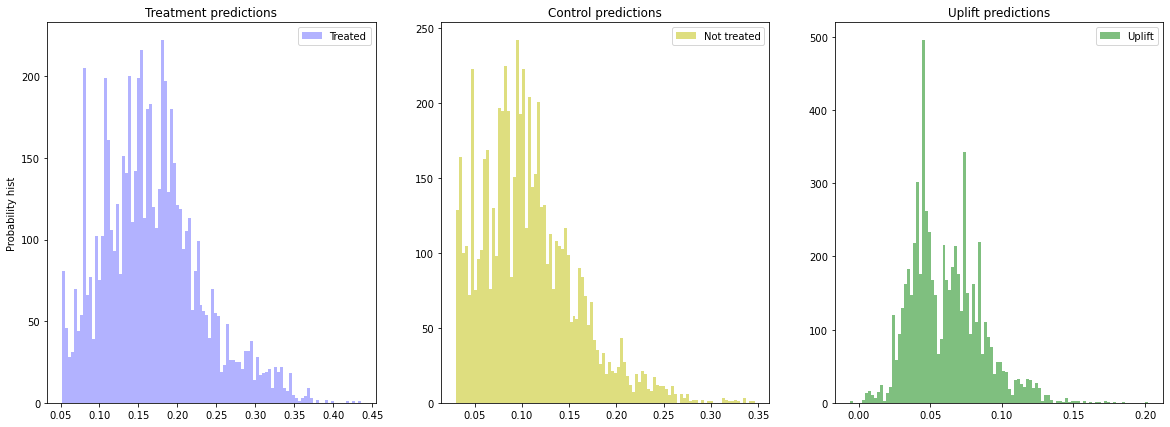

In [42]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=21, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_sm = sm.predict(X_test)

sm_score = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.3)
print(f'uplift@10%: {sm_score:.4f}')
models_results['uplift@10%'].append(sm_score)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [43]:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,22.129542
1,is_referral,19.735170
2,used_bogo,12.353684
3,zip_code,10.811770
4,recency,10.256572
5,used_discount,8.923203
6,history,8.374058
7,channel,7.416000


### ClassTransformation

In [44]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=21, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_features})

uplift_ct = ct.predict(X_test)

ct_score = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.3)

models_results['uplift@10%'].append(ct_score)

### TwoModels

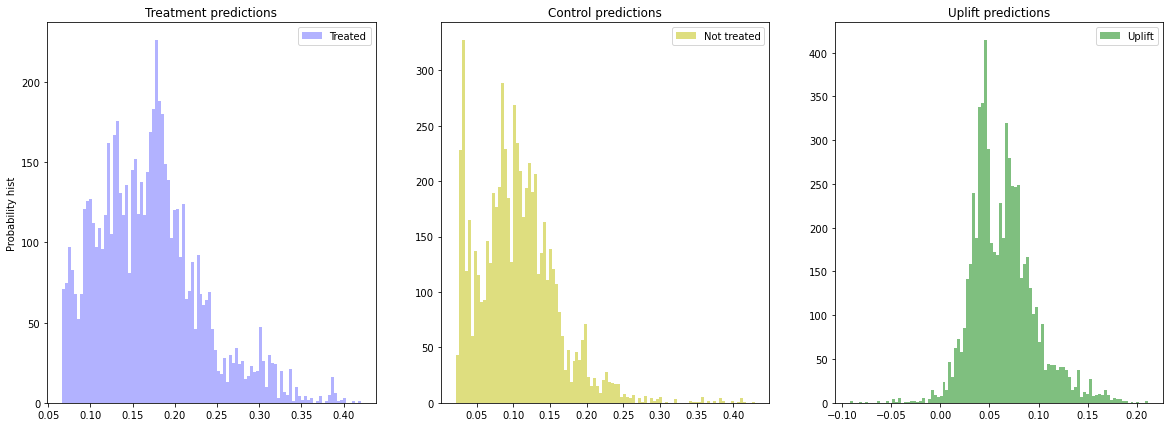

In [45]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=21, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=21, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': cat_features}, 
    estimator_ctrl_fit_params={'cat_features': cat_features}
)

uplift_tm = tm.predict(X_test)

tm_score = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.3)

models_results['uplift@10%'].append(tm_score)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [46]:
models_results

{'approach': ['SoloModel', 'ClassTransformation', 'TwoModels'],
 'uplift@30%': [0.08281222855563902, 0.06776304540225406, 0.07257698931526599],
 'uplift@20%': [0.058585625357888305,
  0.05399757405594449,
  0.07615524810511604],
 'uplift@10%': [0.07046487268006257, 0.06465826718991277, 0.09272987912228417]}

6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей

In [47]:
pd.DataFrame(data=models_results).sort_values('uplift@30%', ascending=False)

,approach,uplift@30%,uplift@20%,uplift@10%
0,SoloModel,0.082812,0.058586,0.070465
2,TwoModels,0.072577,0.076155,0.092730
1,ClassTransformation,0.067763,0.053998,0.064658
